## Setting up the environment

In [ ]:
%pip install -r requirements_02.txt

## Importing the required libraries

In [2]:
import torch
import boto3
import os
import requests
import base64
import pymupdf

import matplotlib.pyplot as plt
import numpy as np

from colpali_engine.models import ColQwen2, ColQwen2Processor
from torch.utils.data import DataLoader
from io import BytesIO
from tqdm import tqdm
from PIL import Image


## Loading the model and processor


In [3]:
# Check if CUDA/MPS is available
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"{device = }")

device = 'cuda'


In [1]:
model_name = "vidore/colqwen2-v0.1"
model = ColQwen2.from_pretrained(
                pretrained_model_name_or_path=model_name,
                torch_dtype=torch.bfloat16,
                device_map=device,
                cache_dir="./model_cache"
            )

In [7]:
from colpali_engine.models import ColQwen2, ColQwen2Processor

model_name = "vidore/colqwen2-v0.1"

# Load processor and override the size
processor = ColQwen2Processor.from_pretrained(
    pretrained_model_name_or_path=model_name,
    cache_dir="./model_cache"
)

# Fix the size to avoid ValueError
processor.image_processor.size = {
    "shortest_edge": 224  # or whatever appropriate size for the model
}


chat_template.json: 0.00B [00:00, ?B/s]

In [8]:
# Setting the model to evaluation mode
model.eval()
model

ColQwen2(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linea

## Downloading the dataset

In [9]:
# Downloading the dataset
url = "https://jmedicalcasereports.biomedcentral.com/counter/pdf/10.1186/s13256-025-05102-8.pdf?_gl=1*1pvoysr*_up*MQ..*_gs*MQ..&gclid=CjwKCAjw1ozEBhAdEiwAn9qbzX0vXIRxOZdvBmvUB-BQ1Ahy6bT3qPQX7qmweskDHcsjI6B0J9w-hxoCBNcQAvD_BwE&gbraid=0AAAAApIOJzq7IKzPIUG82kbMm9k0x1z3S"

# Set the filename and filepath
filename = "Tuberculosis of the elbow joint.pdf"
filepath = os.path.join("data", filename)

# Create the data directory if it doesn't exist
os.makedirs("data", exist_ok=True)

# Download the file
response = requests.get(url)
if response.status_code == 200:
    with open(filepath, 'wb') as file:
        file.write(response.content)
    print(f"File downloaded successfully: {filepath}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded successfully: data/Tuberculosis of the elbow joint.pdf


## Converting PDF to Images


In [10]:
# Define the function to process each page of the PDF
def process_page_images(page, page_num, base_dir):
    # Create a pixmap from the PDF page
    pix = page.get_pixmap()

    # Define the path where the image will be saved
    page_path = os.path.join(base_dir, f"page_{page_num:03d}.jpeg")

    # Save the pixmap as a JPEG image
    pix.save(page_path)

    # Open the saved image file and convert it to a base64 string
    with open(page_path, 'rb') as file:
        encoded_image = base64.b64encode(file.read()).decode('utf8')

    # Convert the base64 string back to a bytes object and create a PIL image
    image_data = BytesIO(base64.b64decode(encoded_image))
    page_image_pil = Image.open(image_data)

    # Return the PIL image object
    return page_image_pil, page_path

In [11]:
doc = pymupdf.open(filepath)
num_pages = len(doc)
output_dir = "data/processed_page_images"

images = []
images_paths = []

# Make sure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Process each page of the PDF
for page_num in tqdm(range(num_pages), desc="Processing PDF pages"):
    page = doc[page_num]
    image, page_path = process_page_images(page, page_num, output_dir)
    images.append(image)
    images_paths.append(page_path)


Processing PDF pages: 100%|██████████| 9/9 [00:00<00:00, 17.77it/s]


In [12]:
# Loading the images into a dataloader
dataloader = DataLoader(
                            dataset=images,
                            batch_size=1,
                            shuffle=False,
                            collate_fn=lambda x: processor.process_images(x),
                        )

images_embeddings  = []

for batch_doc in tqdm(dataloader):
    with torch.no_grad():
        batch_doc = {k: v.to(model.device) for k, v in batch_doc.items()}
        embeddings_doc = model(**batch_doc)
    images_embeddings.extend(list(torch.unbind(embeddings_doc.to("cpu"))))


100%|██████████| 9/9 [00:30<00:00,  3.38s/it]


## Retrieval

In [13]:
def get_results(query, topk):
    batch_queries = processor.process_queries([query]).to(model.device)

    # Forward pass
    with torch.no_grad():
        query_embeddings = model(**batch_queries)

    scores = processor.score_multi_vector(query_embeddings, images_embeddings)
    scores = scores.squeeze(0)

    # get top-k scores
    close_vectors_id = scores.topk(topk).indices.tolist()

    return close_vectors_id

In [14]:
query = "How arthritis and elbow joint pain is related to tuberculosis?"
k = 6

context_ids = get_results(query=query, topk=k)

In [15]:
print(f"Top {k} context ids: {context_ids}")

Top 6 context ids: [0, 5, 7, 1, 2, 6]


In [17]:
def display_images_in_grid(image_ids, images):
    # Number of images
    num_images = len(image_ids)

    # Define the number of columns for the grid
    cols = 3
    # Calculate the number of rows needed
    rows = (num_images + cols - 1) // cols

    # Create a figure with subplots in a grid
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    # Loop through the images and their corresponding axes
    for ax, image_id in zip(axes, image_ids):
        # Resize the image
        shrink_factor = (images[image_id].size[0] / 1024)
        resized_image = images[image_id].resize((int(images[image_id].size[0] / shrink_factor),
                                                 int(images[image_id].size[1] / shrink_factor)))

        # Display the image in the respective subplot
        ax.imshow(resized_image)
        # Set the title for each subplot
        rank = image_ids.index(image_id) + 1
        ax.set_title(f'Rank {rank}')
        # Hide grid lines
        ax.grid(False)
        # Hide axes ticks
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide unused axes if any
    for ax in axes[len(image_ids):]:
        ax.axis('off')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# display_images_in_grid(context_ids, images)

## Interpretability

In [ ]:
# # Closest top K tokens
# context_ids

In [ ]:
# # All image embeddings
# len(images_embeddings), images_embeddings

In [ ]:
# # All images in PIL - JpegImageFile format
# len(images), images

In [18]:
from colpali_engine.interpretability import get_similarity_maps_from_embeddings
from colpali_engine.interpretability import plot_similarity_map

In [22]:
def visualize_similarity_map(image, query, model, processor):

    # Get the device
    device = model.device

    # Prreprocess inputs
    batch_images = processor.process_images([image]).to(device)
    batch_queries = processor.process_queries([query]).to(device)

    # Forward passes
    with torch.no_grad():
        image_embeddings = model.forward(**batch_images)
        query_embeddings = model.forward(**batch_queries)


    # Get the number of image patches
    n_patches = processor.get_n_patches(image_size=image.size,
                                     spatial_merge_size=model.spatial_merge_size)





    # Get the tensor mask to filter out the embeddings that are not related to the image
    image_mask = processor.get_image_mask(batch_images)

    # Generate the similarity maps
    batched_similarity_maps = get_similarity_maps_from_embeddings(
                                                                    image_embeddings=image_embeddings,
                                                                    query_embeddings=query_embeddings,
                                                                    n_patches=n_patches,
                                                                    image_mask=image_mask,
                                                                )

    # Get the similarity map for our (only) input image
    similarity_maps = batched_similarity_maps[0]  # (query_length, n_patches_x, n_patches_y)

    # Tokenize the query
    query_tokens = processor.tokenizer.tokenize(query)
    query_tokens = [item.replace('Ġ', '') for item in query_tokens]

    # Picking a random token
    token_idx = np.random.choice(len(query_tokens))

    # Get the similarity map for our (only) input image
    fig, ax = plot_similarity_map(image,
                                  similarity_maps[token_idx],
                                  figsize=(8, 8),
                                  show_colorbar=False)

    max_sim_score = similarity_maps[token_idx, :, :].max().item()
    ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

    return fig

In [26]:
processor.image_processor.size["longest_edge"] = 602112
processor.image_processor.size["shortest_edge"] = 3136


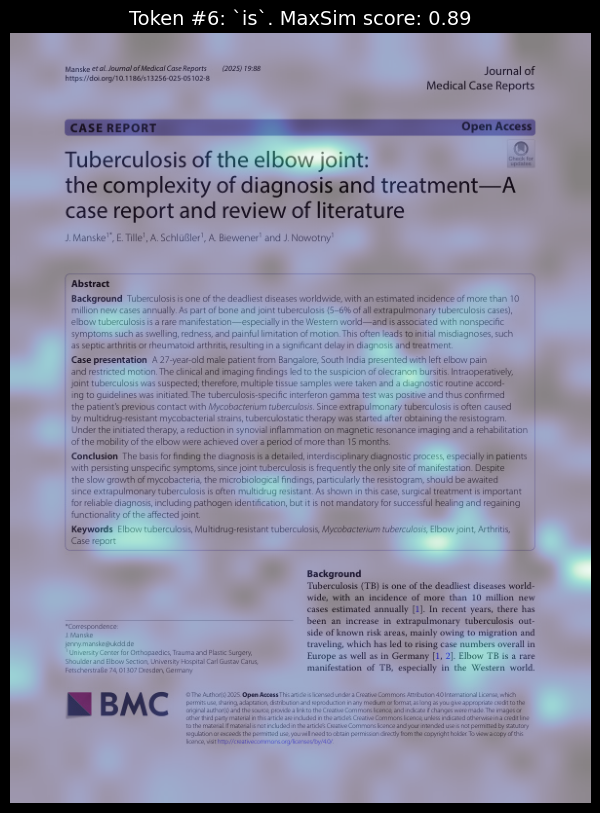

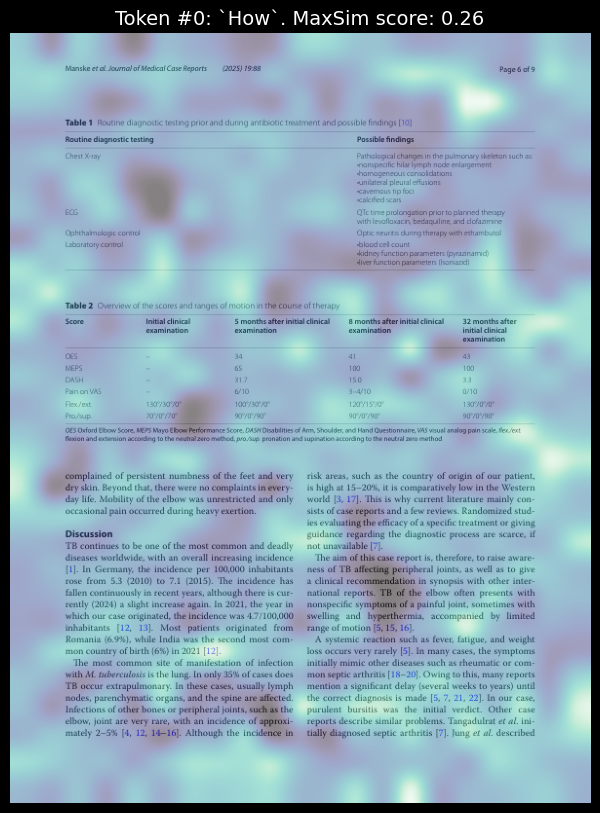

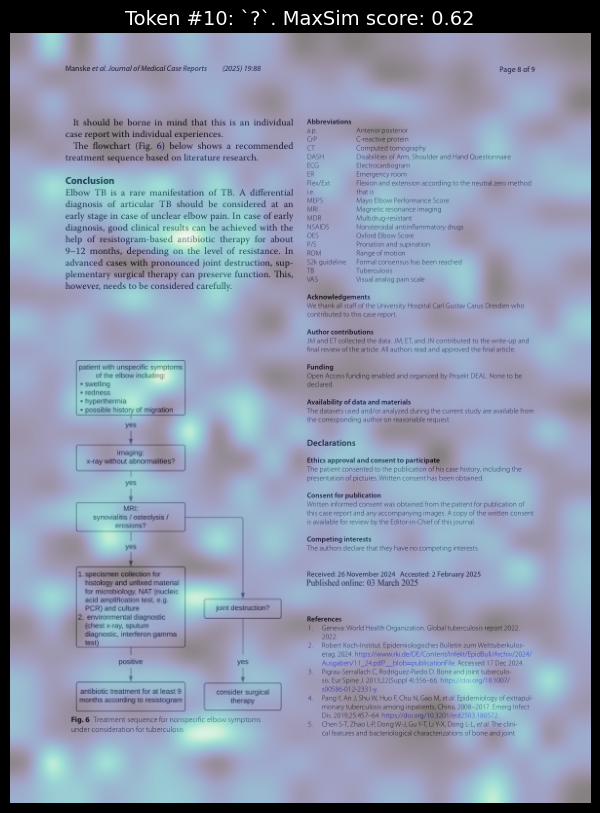

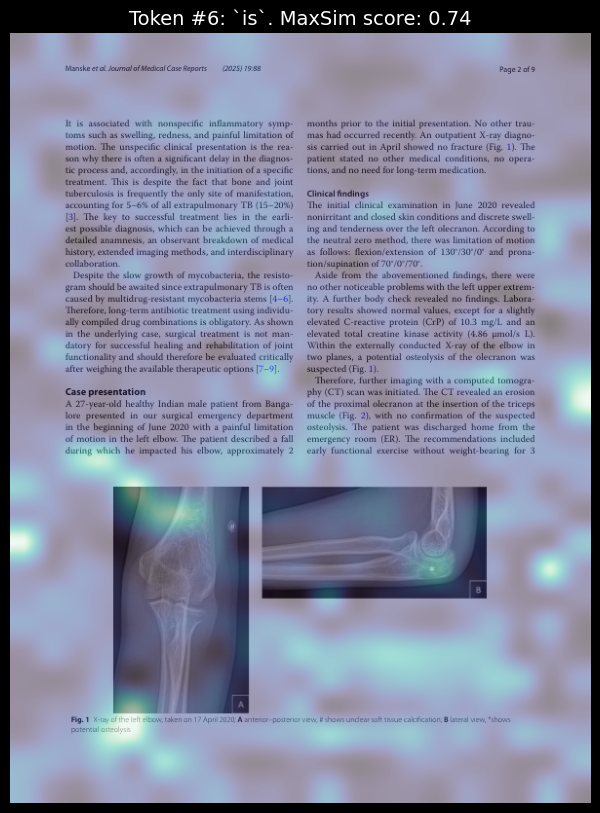

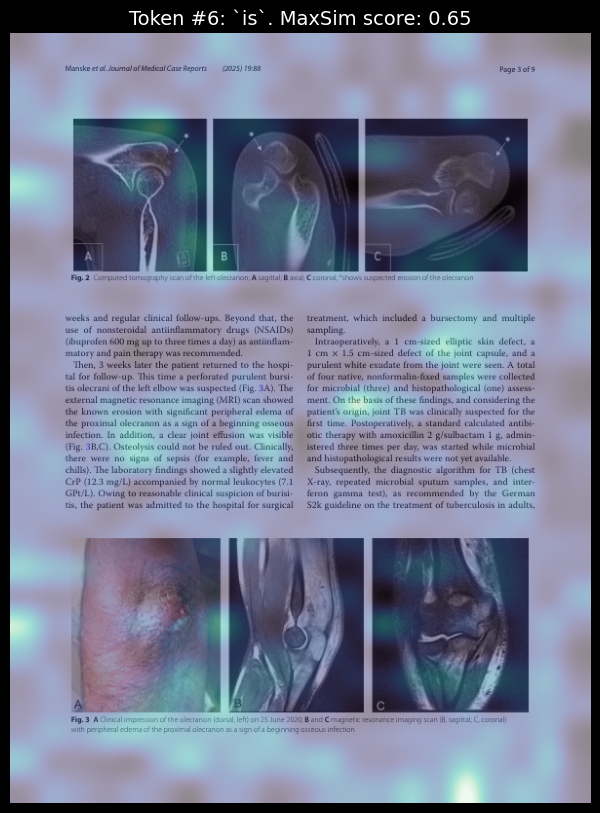

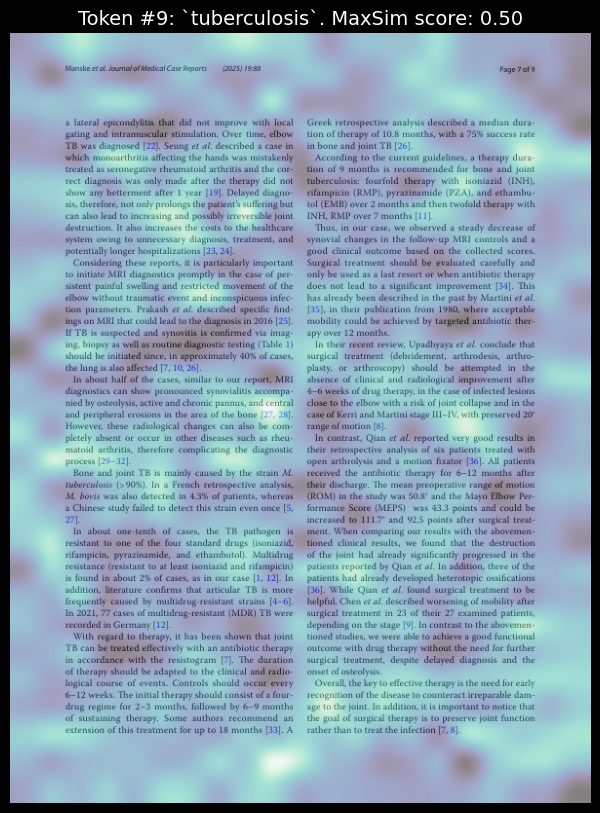

In [27]:
figs = []
for idx in context_ids:
    image = images[idx]
    fig = visualize_similarity_map(image, query, model, processor)
    figs.append(fig)


In [21]:
import inspect
print(inspect.signature(processor.get_n_patches))


(image_size: Tuple[int, int], spatial_merge_size: int) -> Tuple[int, int]


## Generation with Google-Gemini

In [29]:
import google.generativeai as genai
from PIL import Image
import io
import base64
import os
from google.colab import userdata

api_key = userdata.get("GOOGLE_API_KEY")

genai.configure(api_key=api_key)



In [30]:
def read_image_for_gemini(image_path: str):
    """
    Reads the image and returns a PIL Image object.
    Gemini accepts PIL images directly.
    """
    return Image.open(image_path)


def send_images_to_gemini(matched_items: list, query: str, model_name: str = "gemini-1.5-flash-latest"):
    """
    Sends multiple images + a text query to Gemini multimodal model.
    """
    model = genai.GenerativeModel(model_name=model_name)

    # Read images
    images = [read_image_for_gemini(image_path) for image_path in matched_items]

    # Send multimodal prompt
    response = model.generate_content(
        [
            *images,  # list of PIL Images
            query     # user query (text)
        ],
        generation_config={
            "temperature": 0.3,
            "max_output_tokens": 4096,
        }
    )

    return response.text


In [31]:
matched_items = [images_paths[idx] for idx in context_ids]
matched_items

['data/processed_page_images/page_000.jpeg',
 'data/processed_page_images/page_005.jpeg',
 'data/processed_page_images/page_007.jpeg',
 'data/processed_page_images/page_001.jpeg',
 'data/processed_page_images/page_002.jpeg',
 'data/processed_page_images/page_006.jpeg']

In [32]:
result = send_images_to_gemini(matched_items, query)
print(result)

Here's a summary of how arthritis and elbow joint pain relate to tuberculosis (TB) based on the provided text:

Tuberculosis can affect the joints, including the elbow.  While uncommon, TB arthritis in the elbow presents with nonspecific inflammatory symptoms like swelling, redness, and painful limitation of motion.  This can mimic other forms of arthritis, making diagnosis challenging.  The initial symptoms may be subtle and easily mistaken for other conditions.  The diagnosis of TB arthritis requires a thorough evaluation including imaging (X-ray, MRI, CT), laboratory tests (to detect TB bacteria), and sometimes surgical biopsy to confirm the diagnosis.  Treatment involves a prolonged course of anti-tuberculosis medications.  In severe cases, surgery may be necessary to remove damaged tissue and preserve joint function.  The delay in diagnosis can lead to significant joint damage.

